# Spatial Evolutionary Prisoners Dilemma on a Grid

This notebook builds a simple spatial evolutionary prisoners dilemma model and lets you explore when cooperation survives. You will implement the model, visualize dynamics, and run small experiments.

**Learning goals**
1. Implement payoff accumulation from local interactions on a grid
2. Update strategies by imitating the best neighbor
3. Visualize how cooperative clusters form and evolve
4. Run parameter sweeps to find conditions that favor cooperation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(7)  # for reproducibility

## Model parameters

We use a binary strategy grid with 1 for Cooperate and 0 for Defect. Each player plays a prisoners dilemma with all neighbors and sums payoffs.

Default payoffs  
R reward for mutual cooperation  
T temptation to defect against a cooperator  
P punishment for mutual defection  
S sucker payoff when a cooperator meets a defector

Neighborhoods  
Moore includes 8 neighbors  
Von Neumann includes 4 neighbors

In [2]:
# Payoff parameters
R = 3
T = 5
P = 1
S = 0

# Grid and runtime
N = 60            # grid size N by N
steps = 100       # number of rounds
neighborhood = "Moore"  # "Moore" or "VonNeumann"
include_self_in_update = True   # imitate best among neighbors and self

## Initialization helpers

Two options  
1. Random initialization with a given fraction of cooperators  
2. One small cooperative cluster in a sea of defectors

In [3]:
def init_random(N, coop_fraction=0.5):
    return np.random.choice([0, 1], size=(N, N), p=[1 - coop_fraction, coop_fraction])

def init_cluster(N, cluster_size=3):
    g = np.zeros((N, N), dtype=int)
    x0 = N // 2 - cluster_size // 2
    y0 = N // 2 - cluster_size // 2
    g[x0:x0 + cluster_size, y0:y0 + cluster_size] = 1
    return g

# choose one
grid = init_random(N, coop_fraction=0.5)
# grid = init_cluster(N, cluster_size=3)

## Neighborhood counts

We need counts of cooperative and defecting neighbors for each cell. We will use numpy roll to sum over neighbor positions with periodic boundary conditions.

In [4]:
def neighbor_counts(grid, mode="Moore"):
    """Return counts of cooperative neighbors and defecting neighbors for each cell."""
    shifts_moore = [(-1,-1), (-1,0), (-1,1),
                    ( 0,-1),          ( 0,1),
                    ( 1,-1), ( 1,0),  ( 1,1)]
    shifts_vn = [(-1,0), (1,0), (0,-1), (0,1)]
    shifts = shifts_moore if mode == "Moore" else shifts_vn

    coop_sum = np.zeros_like(grid, dtype=int)
    for dx, dy in shifts:
        coop_sum += np.roll(np.roll(grid, dx, axis=0), dy, axis=1)
    deg = len(shifts)
    def_sum = deg - coop_sum  # since strategies are binary
    return coop_sum, def_sum

## Payoff computation

Payoff for each player equals the sum of payoffs from pairwise games with all neighbors

If you play C with nC cooperative neighbors and nD defecting neighbors  
payoff = R times nC plus S times nD

If you play D with nC cooperative neighbors and nD defecting neighbors  
payoff = T times nC plus P times nD

In [5]:
def compute_payoffs(grid, R, T, P, S, mode="Moore"):
    nC, nD = neighbor_counts(grid, mode=mode)
    coop_payoff = R * nC + S * nD
    def_payoff  = T * nC + P * nD
    return np.where(grid == 1, coop_payoff, def_payoff)

## Imitation update

Synchronous imitation of the most successful neighbor  
Each player looks at the payoffs in its neighborhood and adopts the strategy of the highest payoff player. Optionally include the player itself in this comparison.

In [6]:
def imitate_best_neighbor(grid, payoffs, mode="Moore", include_self=True):
    # collect payoff and strategy planes for all neighbor shifts
    if mode == "Moore":
        shifts = [(-1,-1), (-1,0), (-1,1),
                  ( 0,-1),          ( 0,1),
                  ( 1,-1), ( 1,0),  ( 1,1)]
    else:
        shifts = [(-1,0), (1,0), (0,-1), (0,1)]

    planes_pay = []
    planes_str = []

    if include_self:
        planes_pay.append(payoffs)
        planes_str.append(grid)

    for dx, dy in shifts:
        planes_pay.append(np.roll(np.roll(payoffs, dx, axis=0), dy, axis=1))
        planes_str.append(np.roll(np.roll(grid,    dx, axis=0), dy, axis=1))

    # stack and pick argmax over the plane axis
    Pstack = np.stack(planes_pay, axis=0)
    Sstack = np.stack(planes_str, axis=0)
    arg = np.argmax(Pstack, axis=0)
    new_grid = np.take_along_axis(Sstack, arg[None, ...], axis=0)[0]
    return new_grid

## Visualization helper

Blue for cooperators  
Red for defectors  
Also plot fraction of cooperators

In [7]:
def plot_grid(g, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    cmap = plt.matplotlib.colors.ListedColormap(["red", "blue"])
    im = ax.imshow(g, cmap=cmap, vmin=0, vmax=1, interpolation="nearest")
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(title)
    return im

def frac_coop(g):
    return g.mean()

## One simulation run

Run the model for a given number of steps and visualize the start middle and end. Also record the time series of the fraction of cooperators.

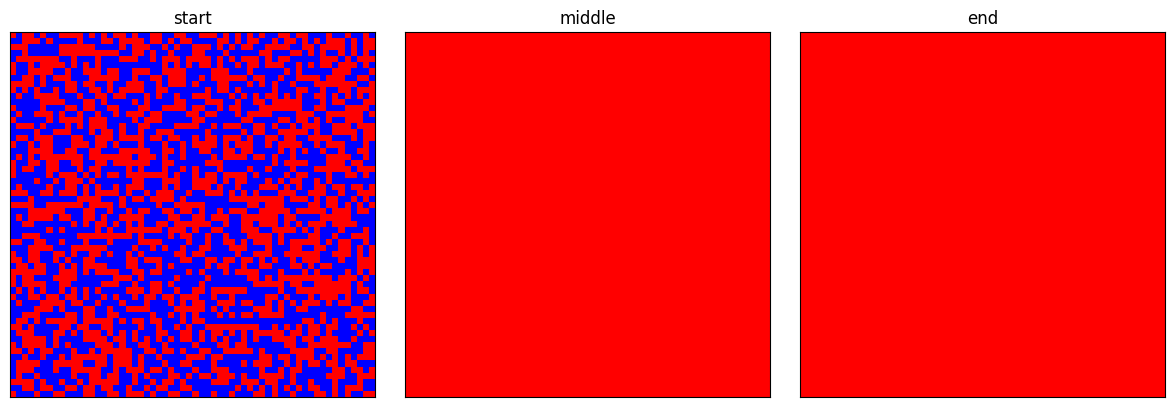

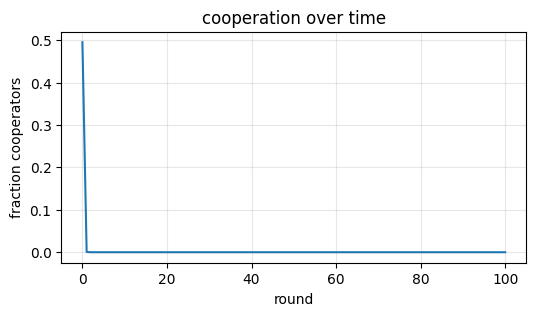

In [8]:
def run_simulation(grid, steps, R, T, P, S, mode="Moore", include_self=True, return_history=False):
    g = grid.copy()
    history = [g.copy()]
    fseries = [frac_coop(g)]
    for t in range(steps):
        pay = compute_payoffs(g, R, T, P, S, mode=mode)
        g = imitate_best_neighbor(g, pay, mode=mode, include_self=include_self)
        history.append(g.copy())
        fseries.append(frac_coop(g))
    if return_history:
        return np.array(history), np.array(fseries)
    return g, np.array(fseries)

# Demo run
grid0 = init_random(N, coop_fraction=0.5)
hist, fts = run_simulation(grid0, steps=steps, R=R, T=T, P=P, S=S,
                           mode=neighborhood, include_self=include_self_in_update, return_history=True)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
plot_grid(hist[0],   ax=axes[0], title="start")
plot_grid(hist[steps//2], ax=axes[1], title="middle")
plot_grid(hist[-1],  ax=axes[2], title="end")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(fts)
plt.xlabel("round")
plt.ylabel("fraction cooperators")
plt.title("cooperation over time")
plt.grid(True, alpha=0.3)
plt.show()

## Experiment 1 vary T

How sensitive is cooperation to temptation T  
We sweep T and record the final fraction of cooperators after a fixed runtime. Each run starts from a fresh random grid with the same initial fraction of cooperators.

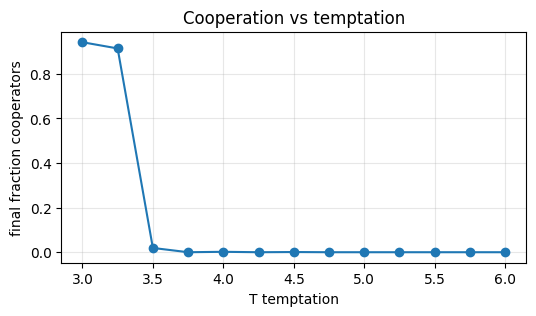

In [9]:
def sweep_T(T_values, N=60, steps=100, init_fraction=0.5, reps=3, mode="Moore"):
    finals = []
    for Tval in T_values:
        vals = []
        for _ in range(reps):
            g0 = init_random(N, coop_fraction=init_fraction)
            _, fts = run_simulation(g0, steps, R=R, T=Tval, P=P, S=S, mode=mode,
                                    include_self=include_self_in_update, return_history=True)
            vals.append(fts[-1])
        finals.append(np.mean(vals))
    return np.array(finals)

T_values = np.linspace(3.0, 6.0, 13)  # sweep across a range around the default
final_frac = sweep_T(T_values, N=N, steps=steps, init_fraction=0.5, reps=3, mode=neighborhood)

plt.figure(figsize=(6,3))
plt.plot(T_values, final_frac, marker="o")
plt.xlabel("T temptation")
plt.ylabel("final fraction cooperators")
plt.title("Cooperation vs temptation")
plt.grid(True, alpha=0.3)
plt.show()

## Experiment 2 survival of a cooperative seed

Start with a small cooperative block in a sea of defectors and observe growth or collapse. We track cluster size over time for different T values.

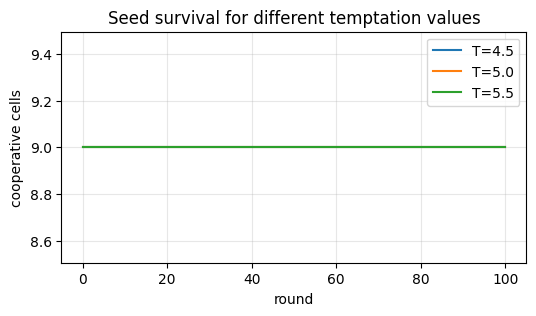

In [10]:
def cluster_size(g):
    return g.sum()

T_scan = [4.5, 5.0, 5.5]
plt.figure(figsize=(6,3))
for Tval in T_scan:
    g0 = init_cluster(N, cluster_size=3)
    _, fts = run_simulation(g0, steps=steps, R=R, T=Tval, P=P, S=S,
                            mode=neighborhood, include_self=include_self_in_update, return_history=True)
    # convert fraction to size for interpretability
    size_series = fts * (N * N)
    plt.plot(size_series, label=f"T={Tval}")
plt.xlabel("round")
plt.ylabel("cooperative cells")
plt.title("Seed survival for different temptation values")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Experiment 3 compare neighborhoods

Compare Moore and Von Neumann neighborhoods with the same parameters and initial condition.

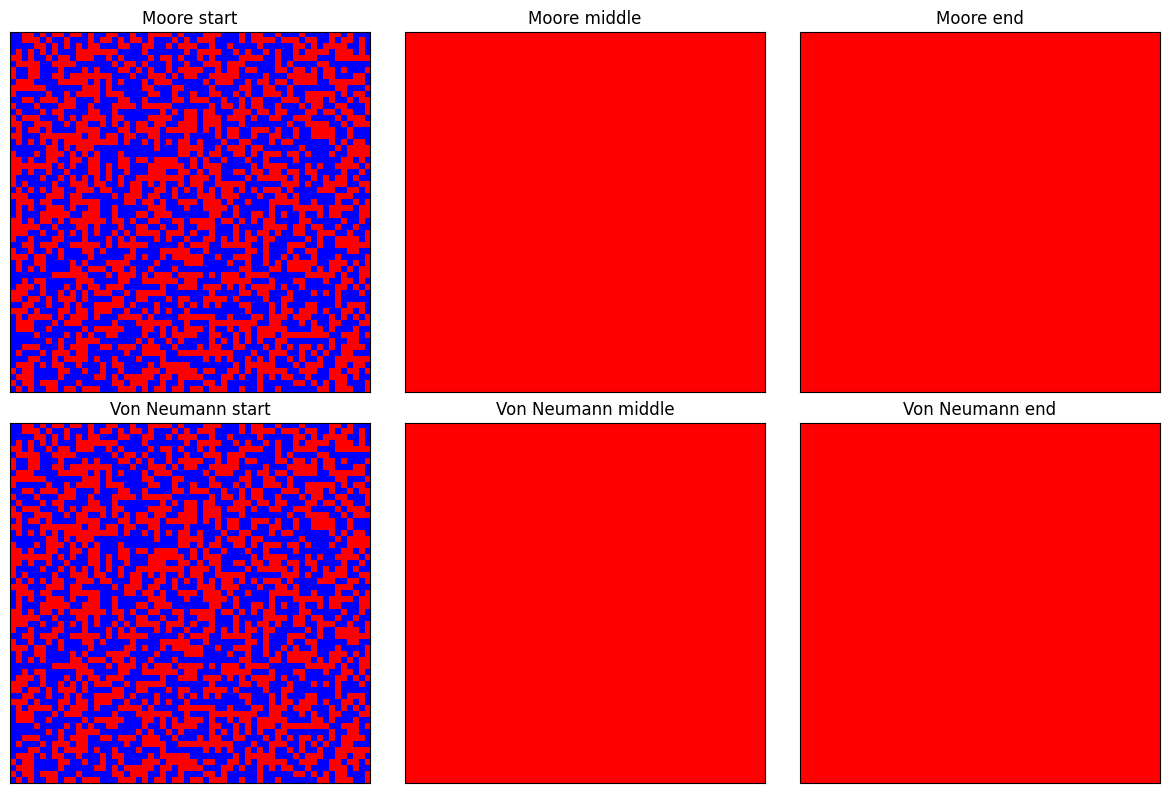

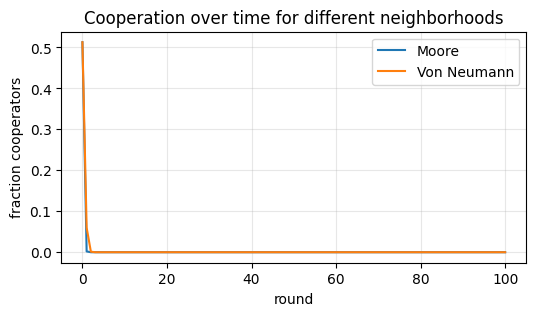

In [11]:
g0 = init_random(N, coop_fraction=0.5)

hist_M, fts_M = run_simulation(g0, steps=steps, R=R, T=T, P=P, S=S,
                               mode="Moore", include_self=include_self_in_update, return_history=True)
hist_V, fts_V = run_simulation(g0, steps=steps, R=R, T=T, P=P, S=S,
                               mode="VonNeumann", include_self=include_self_in_update, return_history=True)

fig, axes = plt.subplots(2, 3, figsize=(12,8))
plot_grid(hist_M[0],         ax=axes[0,0], title="Moore start")
plot_grid(hist_M[steps//2],  ax=axes[0,1], title="Moore middle")
plot_grid(hist_M[-1],        ax=axes[0,2], title="Moore end")

plot_grid(hist_V[0],         ax=axes[1,0], title="Von Neumann start")
plot_grid(hist_V[steps//2],  ax=axes[1,1], title="Von Neumann middle")
plot_grid(hist_V[-1],        ax=axes[1,2], title="Von Neumann end")

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(fts_M, label="Moore")
plt.plot(fts_V, label="Von Neumann")
plt.xlabel("round")
plt.ylabel("fraction cooperators")
plt.title("Cooperation over time for different neighborhoods")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Optional extension mutation or noise

Add a small chance to flip strategy each round. This can either rescue cooperation by seeding new clusters or dissolve clusters by random defection inside.

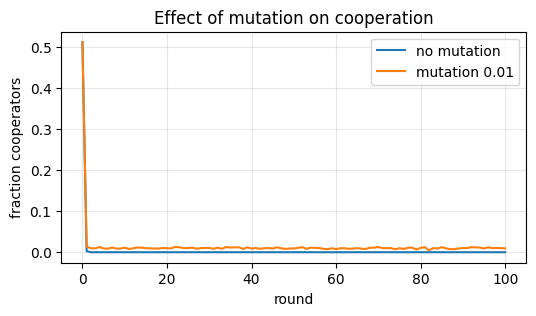

In [12]:
def run_with_mutation(grid, steps, R, T, P, S, mode="Moore", include_self=True, mutation_rate=0.01):
    g = grid.copy()
    fseries = [frac_coop(g)]
    for t in range(steps):
        pay = compute_payoffs(g, R, T, P, S, mode=mode)
        g = imitate_best_neighbor(g, pay, mode=mode, include_self=include_self)
        # random flips with probability mutation_rate
        flips = np.random.rand(*g.shape) < mutation_rate
        g = np.where(flips, 1 - g, g)
        fseries.append(frac_coop(g))
    return g, np.array(fseries)

g0 = init_random(N, coop_fraction=0.5)
_, f_no = run_simulation(g0, steps, R, T, P, S, mode=neighborhood, include_self=include_self_in_update, return_history=True)
_, f_mu = run_with_mutation(g0, steps, R, T, P, S, mode=neighborhood, include_self=include_self_in_update, mutation_rate=0.01)

plt.figure(figsize=(6,3))
plt.plot(f_no, label="no mutation")
plt.plot(f_mu, label="mutation 0.01")
plt.xlabel("round")
plt.ylabel("fraction cooperators")
plt.title("Effect of mutation on cooperation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Conclusions

Key observations from these experiments

1. Spatial structure can allow cooperation to persist by forming clusters
2. Higher temptation T tends to reduce the survival of cooperation
3. Neighborhood choice changes the balance between invasion fronts and cluster stability
4. Small amounts of mutation can either seed new cooperative islands or erode clusters from within

Suggested reflection prompts

What payoff ranges preserve cooperation for your chosen update rule  
How do borders between C and D behave in your runs  
Where do you see tipping points in the parameter sweeps